In [ ]:
#detecting abnormal behaviour in a video
#split the video on frames (5 frames per group)
#split each frame in each group on cubes (1 cube = 80 pic x 80 pic x 5 frames * 3 colour chanels  = 80 x 80 x 15)
# 1 frame = 144 cubes (wall-e video = 720 x 1280  and has ~500 frames; training video has 20 frames)
#for each group find corresponding features = 3d gradient + principal component analysis scaled down to 100 
#find a dictionary for training video sklearn.decomposition.DictionaryLearning.fit - takes time...
#compare vith test features sklearn.decomposition.DictionaryLearning.transform
#calculate error and hilight selected cubes

In [1]:
import imageio
import numpy as np
import sklearn.decomposition as skd
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA

pca = PCA(n_components= 100)

In [2]:
def get_cubes(videoname):
    reader = imageio.get_reader(videoname)
    patches_collection = []
    cubes = []
    i = 0
    for im in reader:
        frame_collection = []
        for y in range(9):
            for x in range(16):
                patch = im[y*80:y*80+80,x*80:x*80+80,:]
                frame_collection.append(patch)
        patches_collection.append(frame_collection)
        i+=1
        if i == 5:
            cubes.append(patches_collection)
            i = 0
            patches_collection = [] 
    cubes = np.array(cubes)
    result = []
    for j in xrange(cubes.shape[0]):
        res = list()
        tmp = cubes[j]
        for i in xrange(tmp.shape[1]):
            res.append(np.concatenate(tmp[:,i], axis=2))
        result.append(res)
    return np.array(result)

def get_features(result):
    global pca
    feats = []
    for j in range(result.shape[0]):
        training_features = []
        training_res = result[j]
        for i in range(len(training_res)):
            grad = np.gradient(training_res[i])
            grad = np.array(grad)
            training_features.append(grad.reshape(-1))
        training_features = np.array(training_features)
        training_features= pca.fit_transform(training_features)
        feats.append(training_features)
    feats = np.array(feats)
    return np.array(feats)

In [3]:
training_cubes = get_cubes('training.mp4')
print training_cubes.shape
training_features = get_features(training_cubes)
print training_features.shape
#(4,144,80,80,15)
#(4,144,100)

(4, 144, 80, 80, 15)
(4, 144, 100)


In [4]:
test_cubes = get_cubes('wall-e.mp4')
print test_cubes.shape
#(100,144,80,80,15)

(100, 144, 80, 80, 15)


In [5]:
test_features = get_features(test_cubes)
print test_features.shape
#(100,144,100)

(100, 144, 100)


In [6]:
reshaped_training_f = np.concatenate(training_features, axis=0)
print reshaped_training_f.shape
#(576,100)

(576, 100)


In [7]:
m = skd.DictionaryLearning(n_components=100)
dic = m.fit(np.array(reshaped_training_f)) 

In [8]:
%timeit m.transform(test_features[0])

10 loops, best of 3: 106 ms per loop


In [9]:
from numpy.linalg import norm
norms_per_cube = []
for i in xrange(test_features.shape[0]):
    features = test_features[i]
    result = m.transform(features) #D*b
    p = features - result #x-D*b
    norms = []
    for i in xrange(result.shape[0]):
        norms.append(norm(p[i,:]))
    norms_per_cube.append(norms)
norms_per_cube = np.array(norms_per_cube)
print norms_per_cube.shape
#(100,144)

(100, 144)


In [10]:
abnormal_indices =[]
for norms in norms_per_cube:
    index = np.array([i for i,v in enumerate(norms) if v >= 40000])
    abnormal_indices.append(index)
print np.array(abnormal_indices).shape
#(100,)

(100,)


In [11]:
test_cubes = get_cubes('wall-e.mp4')

In [29]:
test_copy = test_cubes.copy()
print test_copy[0].shape
result_video = []
i = 0
colors = np.array([1,2,4,5,7,8,10,11,13,14])
for cube_num in xrange(100):
    tmp = test_copy[cube_num]
    index = np.array(abnormal_indices[cube_num])
    for j in index:
        tmp[j,:,:,colors] = 0
    test = np.hstack(tmp[k] for k in range(144))
    recovered = []
    for i in xrange(9):
        recovered.append(test[:,1280*i:1280*i+1280,:])
    recovered = np.vstack(np.array(recovered))
    for pic in xrange(5):
        image = recovered[:,:,3*pic:3*pic+3]
        result_video.append(image)
    
result_video = np.array(result_video)
print result_video.shape

(144, 80, 80, 15)
(500, 720, 1280, 3)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


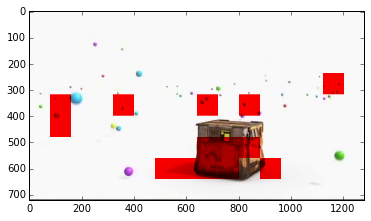

In [28]:
import pylab
%pylab inline 
%config InteractiveShellApp.pylab_import_all = False
im=plt.imshow(result_video[450]) 
plt.show()

In [140]:
import matplotlib.animation as animation
import numpy as np
from pylab import *

dpi = 300
def ani_frame():
    global result_video
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(result_video[0])
    im.set_clim([0,1])
    fig.set_size_inches([5,5])
    tight_layout()

    def update_img(n):
        tmp = result_video[n]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,500,interval=30)
    writer = animation.writers['ffmpeg'](fps=25)

    ani.save('demo4.mp4',writer=writer,dpi=dpi)
    return ani

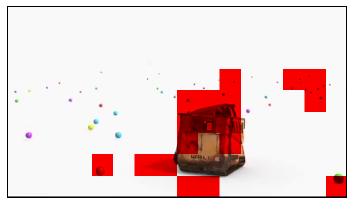

In [141]:
ani = ani_frame()